In [2]:
!pip install yfinance


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from datetime import datetime, timedelta


In [9]:
# Завантаження даних по активу за останні 3 роки
end_date = datetime.today()
start_date = end_date - timedelta(days=1095)  # 3 роки
market_data = yf.download('LDO-USD', start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))

# Використовуємо стовпці 'Close' і 'Volume'
data = market_data[['Close', 'Volume']].values

# Нормалізація даних (мінімум 0, максимум 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

[*********************100%***********************]  1 of 1 completed


In [10]:
# Розбиваємо дані на навчальні та тестові (80% для навчання)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Формуємо послідовності для LSTM
def create_dataset(dataset, look_back=60):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back])
        y.append(dataset[i + look_back, 0])  # Прогнозуємо лише ціну 'Close'
    return np.array(X), np.array(y)

look_back = 60  # Використовуємо дані за останні 60 днів для прогнозування наступного значення
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

# Змінюємо розмірність для LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [11]:
# Додавання випадкового шуму до навчальних даних
noise_factor = 0.01  # Налаштуйте рівень шуму
X_train_noisy = X_train + noise_factor * np.random.normal(size=X_train.shape)
X_train_noisy = np.clip(X_train_noisy, 0, 1)  # Уникаємо виходу за межі нормалізованих значень

In [12]:
# Створюємо модель LSTM з Dropout
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Випадкове вимикання 20% нейронів
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Компіляція моделі
model.compile(optimizer='adam', loss='mean_squared_error')

# Раннє завершення навчання
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Навчання моделі
model.fit(X_train_noisy, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0820 - val_loss: 0.0065
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0115 - val_loss: 0.0162
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0091 - val_loss: 0.0050
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0046 - val_loss: 0.0039
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


/var/folders/m6/cqv1zhq10ds_r6drrn1y2vzw0000gn/T/ipykernel_77508/1242092272.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


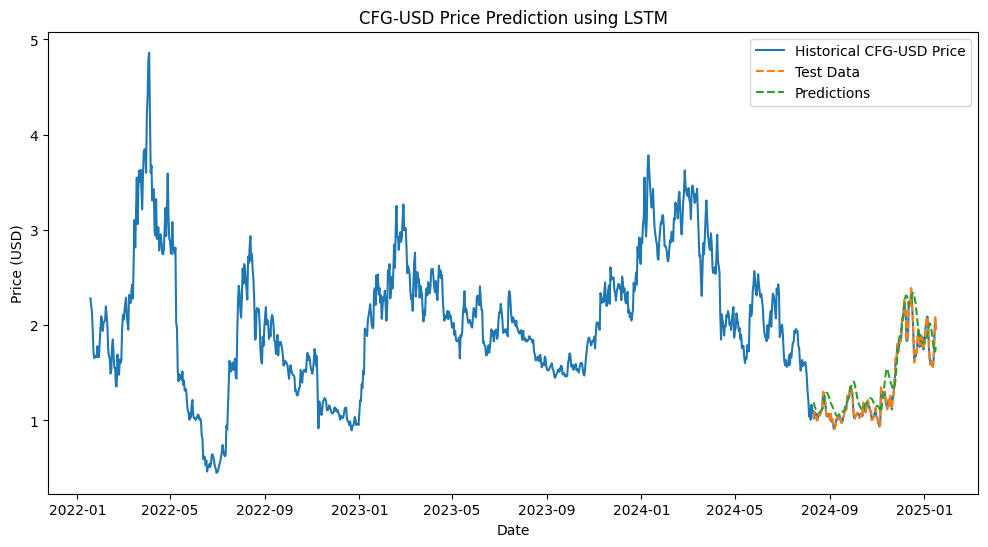

In [14]:
# Прогноз на тестових даних
predictions = model.predict(X_test)
predictions_with_volume = np.concatenate((predictions, np.zeros((predictions.shape[0], 1))), axis=1)
predictions = scaler.inverse_transform(predictions_with_volume)[:, 0]  # Масштабуємо лише стовпець 'Close'

# Обрізаємо тестові дані до довжини прогнозу
valid = market_data[train_size + look_back:]
valid['Predictions'] = predictions

# Побудова графіку історичних та прогнозованих значень
plt.figure(figsize=(12,6))
plt.title('CFG-USD Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.plot(market_data['Close'], label='Historical CFG-USD Price')
plt.plot(valid[['Close', 'Predictions']], label=['Test Data', 'Predictions'], linestyle='--')
plt.legend(loc='best')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

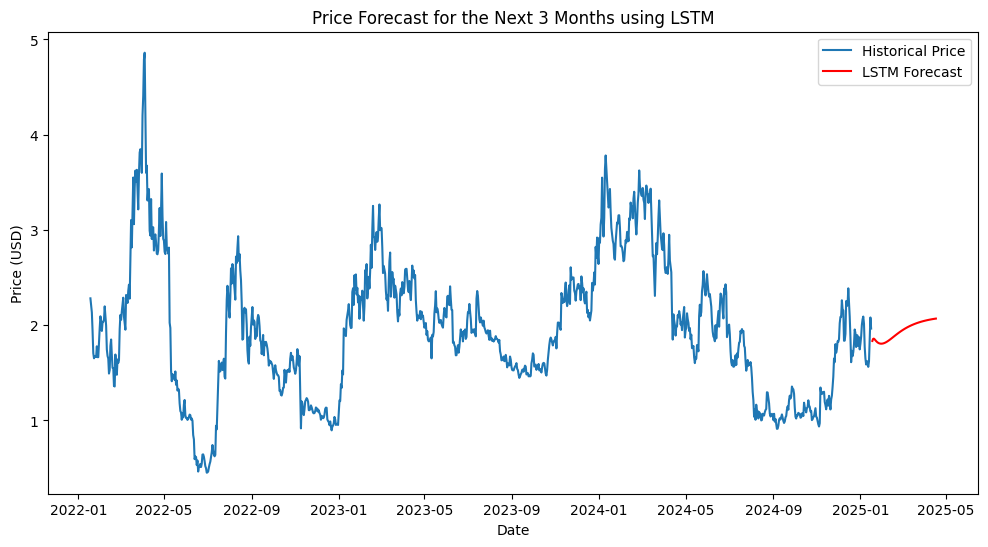

In [15]:
# Прогноз на майбутні 3 місяці (90 днів)
forecast_input = scaled_data[-look_back:]
forecast_input = forecast_input.reshape((1, look_back, 2))

predicted_prices = []
for i in range(90):  # Прогноз на 90 днів вперед
    predicted_price = model.predict(forecast_input)
    predicted_prices.append(predicted_price[0,0])

    # Додаємо штучний стовпець для 'Volume'
    predicted_price_with_volume = np.concatenate((predicted_price, [[0]]), axis=1)
    forecast_input = np.append(forecast_input[:, 1:, :], predicted_price_with_volume.reshape((1, 1, 2)), axis=1)

# Масштабуємо прогнозовані значення назад до оригінального діапазону
predicted_prices_with_volume = np.concatenate((np.array(predicted_prices).reshape(-1, 1), np.zeros((90, 1))), axis=1)
predicted_prices = scaler.inverse_transform(predicted_prices_with_volume)[:, 0]

# Побудова графіку з прогнозом на 3 місяці
future_dates = pd.date_range(end_date, periods=90)
plt.figure(figsize=(12,6))
plt.plot(market_data.index, market_data['Close'], label='Historical Price')
plt.plot(future_dates, predicted_prices, label='LSTM Forecast', color='red')
plt.title('Price Forecast for the Next 3 Months using LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
